# 2D Closest Pair

### What is 2D Closest Pair
The closest pair algorithm finds the two closest points in a set of points. The closest pair algorithm is used in computational geometry for spatial analysis and navigation systems, image analysis for object detection and recognition, and pattern recognition for finding similar objects in a large dataset.

## Code

In [ ]:
#Preamble
import multiprocessing
from time import time
import math
import random
import matplotlib.pyplot as plt

### Sequential Implementation
We'll use the x-coordinate to partition our list of points into two equal parts. The closest pair algorithm will then be applied recursively to each part until the list contains four or fewer points. In such cases, we'll use brute force to find the closest pair. Once the closest pairs from each part are identified, we'll choose the pair with the smaller distance as our reference point. Finally, we'll compare the distance of any pairs of points from opposite halves to the reference distance to identify the closest pair.

The sequential implementation code takes great inspiration from the following:

syphh. (2021, July 24). closest_pair.py [Gist]. GitHub. http://gist.github.com/syphh/b6668694edacf8cc987f89bf1270125c

In [ ]:
def get_distance(p1, p2): #calculate euclidean distance b/w 2 points
  return math.sqrt((p1[0] - p2[0])**2 + (p1[1] - p2[1])**2) 

In [ ]:
#finds closest pairs across adjacent chunks
def merge_closest(y_sorted, pivot, l1, l2, ld, r1, r2, rd):
  p1, p2, d = (l1, l2, ld) if ld < rd else (r1, r2, rd) #consider the pair with the smaller distance from b/w the closest pairs in both chunks

  rem = []
  for point in y_sorted: #consider only the points that lie close enough to the division point/pivot to have a smaller distance than the previous closest pair
    if abs(point[0]-pivot[0]) < d:
      rem.append(point)
  
  for i in range(len(rem)): #go through each point in the strip from top to bottom
    for j in range(i+1, len(rem)): 
      if abs(rem[j][1] - rem[i][1]) >= d: #if the distance in y value is already greater than d then move to the next point. Note that due to d being a previous closest distance, this ensures that a maximum of 7 points are iterated per point making the complexity of the nested loop O(7n) = O(n)
        break
      else:
        cur_d = get_distance(rem[i], rem[j])
        if cur_d < d:
          p1, p2, d = rem[i], rem[j], cur_d

  return p1, p2, d

In [ ]:
def closest_pair(x_sorted, y_sorted):
  if len(x_sorted) <= 4: #base case
    return brute_force(x_sorted)
  
  #divide - prepare input for each half of the data
  mid = len(x_sorted)//2
  pivot = x_sorted[mid]
  x_1 = x_sorted[:mid+1]
  y_1 = []
  x_2 = x_sorted[mid+1:]
  y_2 = []

  #maintains the sorted order of y sublists
  for point in y_sorted:
    if point[0] < pivot[0] or (point[0] == pivot[0] and point[1] <= pivot[1]):
      y_1.append(point)
    else:
      y_2.append(point)

  #conquer - closest point in each half
  l1, l2, ld = left_closest = closest_pair(x_1, y_1)
  r1, r2, rd = right_closest = closest_pair(x_2, y_2)
  
  #merge
  return merge_closest(y_sorted, pivot, l1, l2, ld, r1, r2, rd)

In [ ]:
#check a distance of each point with every other point
def brute_force(A):
  d = None
  for i in range(len(A)):
    for j in range(i+1, len(A)):
      cur_d = get_distance(A[i], A[j])
      
      if d is None or cur_d < d:
        p1, p2, d = A[i], A[j], cur_d
        
  return p1, p2, d

In [ ]:
#does initial sorting of list
def closest_pair_wrapper(points):
  x_sorted = sorted(points)
  y_sorted = sorted(points, key = lambda x:x[1])
  return closest_pair(x_sorted, y_sorted)

### Parallel Implementation
To parallelize the sorting process, we divide the list into chunks based on the desired number of processes. Each chunk is then processed in parallel to find their respective closest pair. After that, we compare the distance between any pairs of points in different but adjacent chunks to find the smallest pair across both chunks. This process is repeated iteratively until there is only one chunk left. The closest pair in that chunk will be the overall closest pair.

In [ ]:
def parr_closest_pair(A, n):
  x_sorted = sorted(A)
  y_sorted = sorted(A, key = lambda x:x[1])

  #break data into chunks - last chunk may have more data than others if input size is not completely divisible
  chunk_size = len(A) // n
  upper_limits = [x_sorted[(i+1)*chunk_size - 1] if i < n - 1 else x_sorted[-1] for i in range(n)]

  x_i = [x_sorted[i*chunk_size:(i+1)*chunk_size] if i < n-1 else x_sorted[i*chunk_size:] for i in range(n)]
  y_i = [[] for i in range(n)]

  #maintains sorted order of y sublists when creating chunks
  for point in y_sorted:
    for i, upper_limit in enumerate(upper_limits):
      if point[0] < upper_limit[0] or (point[0] == upper_limit[0] and point[1] <= upper_limit[1]):
        y_i[i].append(point)
        break

  #find closest pair of each chunk in parallel
  with multiprocessing.Pool() as pool:
    result = pool.imap(worker_func, zip(x_i, y_i))
    chunks = []
    for res in result:
      chunks.append(res)
    
  #merge chunks of similar size iteratively until final closest pair obtained
  while len(chunks) > 1:
    new_chunks = []
    y_i = [merge_lsts(y_i[i], y_i[i+1] if i+1 < len(y_i) else []) for i in range(0, len(y_i), 2)]

    for i in range(0, len(chunks), 2):
      if i + 1 < len(chunks):
        new_chunks.append(merge_closest(y_i[i//2], upper_limits[i], *chunks[i], *chunks[i+1]))
      else:
        new_chunks.append(chunks[i])
        
    upper_limits = [upper_limits[i+1] if i + 1 < len(y_i) else upper_limits[i] for i in range(0, len(upper_limits), 2)]
    chunks = new_chunks

  return chunks[0]

In [ ]:
#combines 2 sorted lists to maintain sorted order. Used when merging chunks
def merge_lsts(y_1, y_2):
  i = j = 0
  y_sorted = []

  while i + j < len(y_1) + len(y_2):
    if j == len(y_2) or (i < len(y_1) and y_1[i][1] <= y_2[j][1]):
      y_sorted.append(y_1[i])
      i += 1
    else:
      y_sorted.append(y_2[j])
      j += 1

  return y_sorted

In [ ]:
#parameter input handling
def worker_func(arrayTuple):
  x_sorted = arrayTuple[0]
  y_sorted = arrayTuple[1]
  return closest_pair(x_sorted, y_sorted)

In [ ]:
def parr_closest_pair_wrapper(A):
  return parr_closest_pair(A, min(8, len(A)//4)) #min prevents errors in cases where lists are too small for division into chunks

### Algorithm Analysis

Algorithm Validity

In [ ]:
#Generate Random points across a grid with -100 <= x <= 100 and -100 <= y <= 100
def generatePoints(n):
  points = [(random.randint(-100,100), random.randint(-100,100)) for i in range(n)]
  return points

In [ ]:
A = generatePoints(10)
print(brute_force(A))
print(closest_pair_wrapper(A))
print(parr_closest_pair_wrapper(A))

((83, -62), (97, -55), 15.652475842498529)
((83, -62), (97, -55), 15.652475842498529)
((83, -62), (97, -55), 15.652475842498529)


In [ ]:
#Check Validity of Closest Pair Algorithm by using 100 test cases
def check_validity(closest_pair_func):
  valid = True
  for i in range(3,50):
    points = generatePoints(i**2)
    valid &= closest_pair_func(points)[2] == brute_force(points)[2]
  return valid

In [ ]:
print(check_validity(closest_pair_wrapper))
print(check_validity(parr_closest_pair_wrapper))

True
True


Time Analysis

In [ ]:
#find average time over a given number of runs of searching the list (lst) of size sz using the given search function.
def calculateExecutionTime(pair_finder, pointsGenerator, size, runs):
  totalTime = 0 #store total time across all runs
  for i in range(runs):
    points = pointsGenerator(size)
    start_time = time()
    pair_finder(points)
    end_time = time()
    totalTime += end_time - start_time #add the time taken to run the given search function
  return totalTime/runs #return average time

Sequential Closest Pair times:  [0.36039156913757325, 1.0843229293823242, 4.285893821716309, 7.298755788803101]
Parallel Closest Pair times:  [0.6396952152252198, 1.5296821117401123, 4.745017671585083, 8.50159707069397]


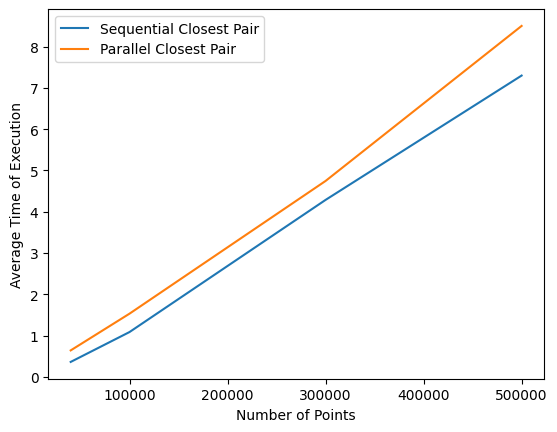

In [ ]:
sizes = [40000, 100000, 300000, 500000] #the different list sizes
cp_times = [] #to store the avg time taken for the different lists for linear search
p_cp_times = [] #to store the avg time taken for the different lists for sentinel search

runs = 5 #number of runs the time is averaged over

for size in sizes:
    points = generatePoints(size)
    cp_times.append(calculateExecutionTime(closest_pair_wrapper, generatePoints, size, runs))
    p_cp_times.append(calculateExecutionTime(parr_closest_pair_wrapper, generatePoints, size, runs))

print("Sequential Closest Pair times: ", cp_times)
print("Parallel Closest Pair times: ", p_cp_times)

#plot graph of time against number of items
plt.plot(sizes, cp_times, label="Sequential Closest Pair")
plt.plot(sizes, p_cp_times, label="Parallel Closest Pair")

plt.legend(loc="upper left")
plt.xlabel('Number of Points')
plt.ylabel('Average Time of Execution')
plt.show()

Above is Google Colab result

In [ ]:
sizes = [10000, 40000, 100000, 300000, 500000, 800000, 1000000] #the different list sizes
cp_times = [] #to store the avg time taken for the different lists for linear search
p_cp_times = [] #to store the avg time taken for the different lists for sentinel search

runs = 10 #number of runs the time is averaged over

for size in sizes:
    points = generatePoints(size)
    cp_times.append(calculateExecutionTime(closest_pair_wrapper, generatePoints, size, runs))
    p_cp_times.append(calculateExecutionTime(parr_closest_pair_wrapper, generatePoints, size, runs))

print("Sequential Closest Pair times: ", cp_times)
print("Parallel Closest Pair times: ", p_cp_times)

#plot graph of time against number of items
plt.plot(sizes, cp_times, label="Sequential Closest Pair")
plt.plot(sizes, p_cp_times, label="Parallel Closest Pair")

plt.legend(loc="upper left")
plt.xlabel('Number of Points')
plt.ylabel('Average Time of Execution')
plt.show()

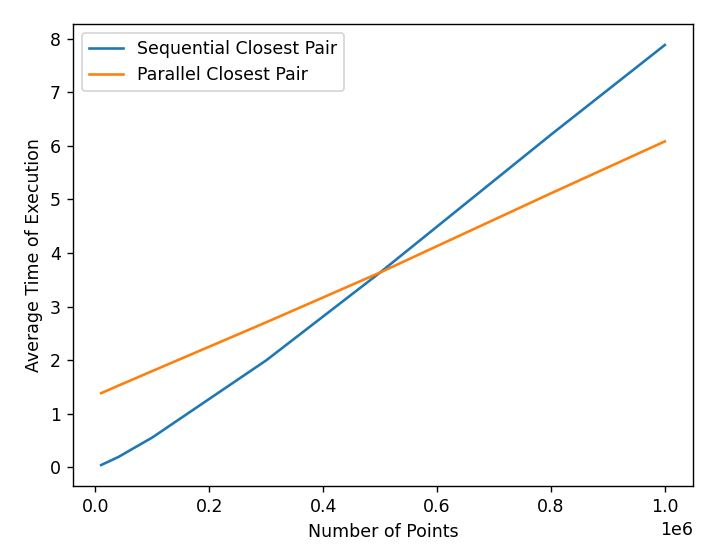

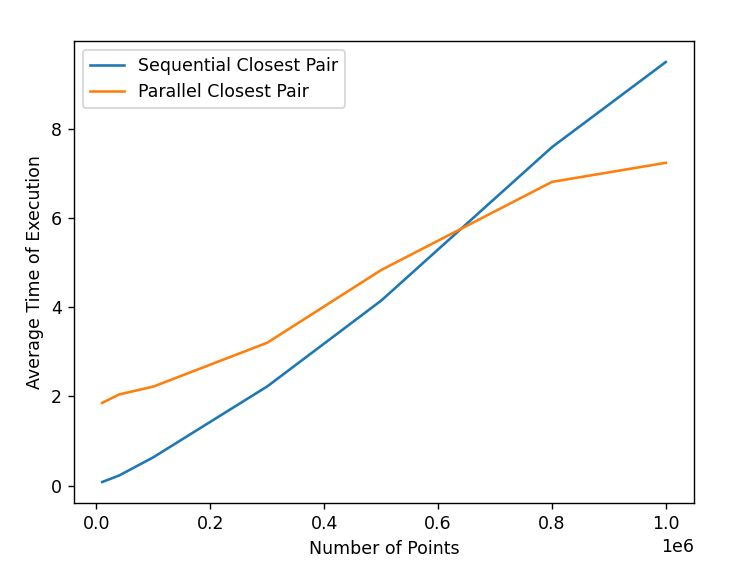

### Result
As the size of the data increases, the parallel algorithm performs better than the sequential one. Moreover, the general shape of the graph seems to be similar. This shows that a parallel algorithm has a similar time complexity but a smaller coefficient which is what we expected. The longer time of execution for smaller inputs indicates that creating a new process has a significant overhead which becomes worthwhile for larger data chunks.